## Create (and visualize) a DNN architecture to perform a binary classification on the dataset.

> **Methods at a glance.** Binary DNN (Linear→BatchNorm→ReLU→Dropout blocks, 1-logit output), trained with BCEWithLogits + Adam. **Stratified 5-fold** CV with leakage-safe scaling inside each fold. **Hyperparameter focus:** learning-rate sweep (1e-4 to 3e-3). **Baselines:** Logistic Regression (from HW3). **Metrics:** Accuracy and ROC-AUC; paired t-tests on per-fold scores.


In [1]:
import sys, site, platform
print("Python:", sys.executable)
print("Site-packages:", site.getsitepackages() if hasattr(site, "getsitepackages") else site.getusersitepackages())
print("Platform:", platform.platform())


Python: c:\Users\elean\anaconda3\envs\3.12.7-env\python.exe
Site-packages: ['c:\\Users\\elean\\anaconda3\\envs\\3.12.7-env', 'c:\\Users\\elean\\anaconda3\\envs\\3.12.7-env\\Lib\\site-packages']
Platform: Windows-11-10.0.26200-SP0


In [2]:
#Install PyTorch into the current VS Code Jupyter kernel
import sys

print("Installing torch into:", sys.executable)
!"{sys.executable}" -m pip install torch --index-url https://download.pytorch.org/whl/cpu


Installing torch into: c:\Users\elean\anaconda3\envs\3.12.7-env\python.exe
Looking in indexes: https://download.pytorch.org/whl/cpu


In [3]:
# 0) Imports
import os, json, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [4]:
from pathlib import Path
import pandas as pd

#1) Set local path (use raw string)
DATA_PATH = Path(r"C:\Users\elean\OneDrive - University of Virginia\Documents\DS 3001\HW4\HW3.jsonl")

#2) Sanity check
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Could not find file at:\n{DATA_PATH}\n"
                            "Tip: Check spelling, spaces, and that you used an r-string or doubled backslashes.")

#3) Robust JSON/JSONL loader
def load_json_maybe_jsonl(path: Path) -> pd.DataFrame:
    # Try JSON Lines first
    try:
        df_try = pd.read_json(path, lines=True)
        if isinstance(df_try, pd.DataFrame) and not df_try.empty:
            return df_try
    except ValueError:
        pass

    # If that failed, try normal JSON (array of objects)
    try:
        return pd.read_json(path, lines=False)
    except ValueError as e:
        raise ValueError(f"Failed to read file as JSONL or JSON. "
                         f"If your file is CSV/TSV, use pd.read_csv instead.\nOriginal error: {e}")

df = load_json_maybe_jsonl(DATA_PATH)

print("Shape:", df.shape)
display(df.head())


Shape: (2000, 3)


,x,y,l
0,0.272207,0.672364,0
1,0.031941,2.272835,0
2,0.871286,-0.105992,0
3,1.252878,1.101521,0
4,1.884091,2.294689,0


In [5]:
# Step 2 (robust): choose/binarize target for binary classification

# A) If dataset already has a binary column, put it here and skip binarization:
# TARGET_COL = "label" 

PREFERRED_BIN = ["label","target","class","is_fraud","is_spam","clicked","churn","default"]
TARGET_COL = next((c for c in PREFERRED_BIN if c in df.columns), None)

if TARGET_COL is not None:
    y_raw = df[TARGET_COL]
    # normalize to {0,1}
    if y_raw.dtype == bool:
        y = y_raw.astype(int)
    else:
        uniq = pd.Series(y_raw.dropna().unique())
        if len(uniq) == 2:
            vals = sorted(uniq.tolist())
            mapping = {vals[0]:0, vals[1]:1}
            y = y_raw.map(mapping).astype(int)
        else:
            raise ValueError(f"Chosen target '{TARGET_COL}' is not binary. Uniques sample: {uniq[:10].tolist()}")
else:
    # B) No binary label found -> use 'y' and BINARIZE it
    assert "y" in df.columns, "No obvious label found and no 'y' column present."
    TARGET_COL = "y"
    y_raw = pd.to_numeric(df["y"], errors="coerce")

    # pick ONE strategy
    BIN_STRATEGY = "median"   # options: "median", "zero", "top_quartile"
    if BIN_STRATEGY == "median":
        thr = y_raw.median()
        y = (y_raw >= thr).astype(int)
        thr_desc = f"median={thr:.4f}"
    elif BIN_STRATEGY == "zero":
        y = (y_raw > 0).astype(int)
        thr_desc = "zero"
    elif BIN_STRATEGY == "top_quartile":
        thr = y_raw.quantile(0.75)
        y = (y_raw >= thr).astype(int)
        thr_desc = f"q75={thr:.4f}"
    else:
        raise ValueError("Unknown BIN_STRATEGY")

print(f"Using target: {TARGET_COL}")
print("Class balance:", pd.Series(y).value_counts(normalize=True).round(3).to_dict())
if TARGET_COL == "y":
    print(f"Binarization strategy: {BIN_STRATEGY} ({thr_desc})")

# Build features after y is defined
X = df.drop(columns=[TARGET_COL])


Using target: y
Class balance: {0: 0.5, 1: 0.5}
Binarization strategy: median (median=3.0031)


In [6]:
# 3) Feature engineering
X = df.drop(columns=[TARGET_COL])

# Split numeric vs categorical
numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols     = [c for c in X.columns if c not in numeric_cols]

print(f"# numeric cols: {len(numeric_cols)} | # categorical cols: {len(cat_cols)}")

# Impute basic missing values
for c in numeric_cols:
    X[c] = X[c].fillna(X[c].median())
for c in cat_cols:
    X[c] = X[c].astype("category").cat.add_categories(["__NA__"]).fillna("__NA__")

# One-hot encode categoricals (drop_first=False to be safe for inference)
if len(cat_cols) > 0:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=False)

# Standardize numerics (after one-hot)
scaler = StandardScaler()
num_mask = np.array([col in numeric_cols for col in X.columns])
X_values = X.values.astype(np.float32)

# Scale only the numeric columns
X_values[:, num_mask] = scaler.fit_transform(X_values[:, num_mask])

print("Final feature shape:", X_values.shape)

# numeric cols: 2 | # categorical cols: 0
Final feature shape: (2000, 2)


In [8]:
from sklearn.model_selection import train_test_split
import numpy as np

# --- Ensure reproducibility seed and labels are valid ---
RNG_SEED = 42  # set if not already
# y as 1-D integer labels (0/1), not float32, not 2-D
y_arr = np.asarray(y).astype(int).ravel()

# --- First split: Train vs Temp (Val+Test) with stratify ---
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_values, y_arr, test_size=0.30, random_state=RNG_SEED, stratify=y_arr
)

# --- Second split: Temp -> Val/Test with stratify if feasible ---
# If any class in y_tmp has < 2 samples, stratified split will error. Guard it:
class_counts_tmp = np.bincount(y_tmp) if y_tmp.ndim == 1 else np.bincount(y_tmp.ravel())
can_stratify_tmp = (class_counts_tmp.min() >= 2)

if can_stratify_tmp:
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=0.50, random_state=RNG_SEED, stratify=y_tmp
    )
else:
    # Fallback: non-stratified second split (or tweak sizes)
    X_val, X_test, y_val, y_test = train_test_split(
        X_tmp, y_tmp, test_size=0.50, random_state=RNG_SEED
    )

print("Shapes ->",
      "Train:", X_train.shape,
      "Val:", X_val.shape,
      "Test:", X_test.shape)

# Helpful sanity checks:
def show_label_dist(name, arr):
    counts = np.bincount(arr)
    total = counts.sum()
    print(f"{name} label dist:", {i:int(c) for i,c in enumerate(counts)}, 
          " | ratio:", [round(c/total,3) for c in counts])

show_label_dist("y_train", y_train)
show_label_dist("y_val", y_val)
show_label_dist("y_test", y_test)


Shapes -> Train: (1400, 2) Val: (300, 2) Test: (300, 2)
y_train label dist: {0: 700, 1: 700}  | ratio: [0.5, 0.5]
y_val label dist: {0: 150, 1: 150}  | ratio: [0.5, 0.5]
y_test label dist: {0: 150, 1: 150}  | ratio: [0.5, 0.5]


In [ ]:
# 5) Torch datasets & loaders
def to_loader(X, y, batch_size=256, shuffle=False):
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = to_loader(X_train, y_train, batch_size=256, shuffle=True)
val_loader   = to_loader(X_val,   y_val,   batch_size=512, shuffle=False)
test_loader  = to_loader(X_test,  y_test,  batch_size=512, shuffle=False)

In [ ]:
# 6) Define a DNN for tabular binary classification
class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden: List[int], p_drop: float=0.2):
        super().__init__()
        layers = []
        last = in_dim
        for h in hidden:
            layers += [
                nn.Linear(last, h),
                nn.BatchNorm1d(h),
                nn.ReLU(),
                nn.Dropout(p_drop),
            ]
            last = h
        layers += [nn.Linear(last, 1)]  # output logit
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(1)  # logits

in_dim = X_train.shape[1]
hidden_layers = [256, 128, 64]
model = MLP(in_dim, hidden_layers, p_drop=0.25)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [11]:
print("in_dim:", in_dim)
print("X shape:", X.shape)
print("First 25 feature cols:", list(X.columns)[:25])
assert in_dim == X.shape[1], "Mismatch: in_dim should equal number of columns in X"


in_dim: 2
X shape: (2000, 2)
First 25 feature cols: ['x', 'l']


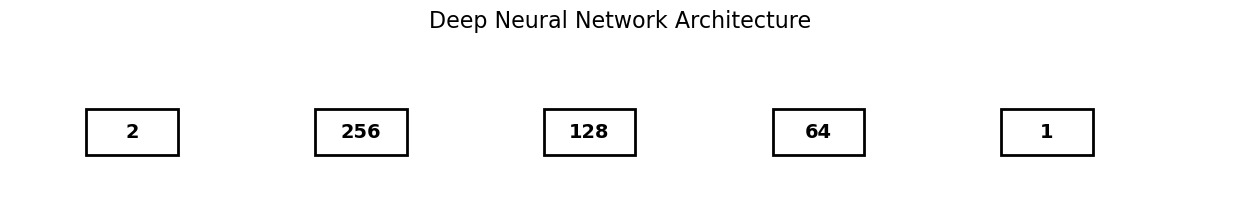

In [12]:
# Much clearer DNN architecture visualization
def plot_architecture(in_dim, hidden, out_dim=1):
    sizes = [in_dim] + hidden + [out_dim]
    n_layers = len(sizes)
    
    fig_width = max(8, n_layers * 2.5)   # make it wider for more layers
    fig_height = 6                       # tall enough to read
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    y = 0.5
    x_spacing = 3
    
    for i, s in enumerate(sizes):
        ax.add_patch(plt.Rectangle((i * x_spacing, y - 0.3), 1.2, 0.6, fill=False, lw=2))
        ax.text(i * x_spacing + 0.6, y, f"{s}", ha='center', va='center', fontsize=14, weight='bold')
        if i < n_layers - 1:
            ax.annotate("", xy=((i+1)*x_spacing - 1.8, y),
                        xytext=(i*x_spacing + 1.2, y),
                        arrowprops=dict(arrowstyle="->", lw=2))
    
    ax.set_xlim(-1, n_layers * x_spacing)
    ax.set_ylim(-0.5, 1.5)
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_title("Deep Neural Network Architecture", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

# Example call:
plot_architecture(in_dim, hidden_layers, 1)


In [14]:
# --- Device (if not already defined) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 8) Training loop with early stopping (robust)
def train_model(model, train_loader, val_loader, max_epochs=50, lr=1e-3, patience=6, pos_weight=None):
    """
    Trains a binary classifier with BCEWithLogitsLoss.
    Assumes model(x) -> shape (batch, 1) logits.
    Targets can be 0/1 int/float; will be cast & reshaped to (batch,1).
    """
    # Loss (optionally support class imbalance)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val = float("inf")
    wait = 0
    # Initialize best_state to current weights so restore never fails
    best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    hist = {"train_loss": [], "val_loss": [], "val_acc": [], "val_auc": []}

    model.to(device)

    for epoch in range(1, max_epochs + 1):
        # ---- Train ----
        model.train()
        tr_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            # ensure float targets with shape (B,1)
            yb = yb.to(device).float().view(-1, 1)

            optimizer.zero_grad()
            logits = model(xb)                    # (B,1)
            loss = criterion(logits, yb)          # BCE-with-logits
            loss.backward()
            optimizer.step()
            tr_loss += loss.item() * xb.size(0)
        tr_loss /= len(train_loader.dataset)

        # ---- Validate ----
        model.eval()
        vl_loss = 0.0
        all_probs = []
        all_true = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device).float().view(-1, 1)
                logits = model(xb)
                loss = criterion(logits, yb)
                vl_loss += loss.item() * xb.size(0)

                probs = torch.sigmoid(logits).squeeze(1)      # (B,)
                all_probs.append(probs.cpu().numpy())
                all_true.append(yb.squeeze(1).cpu().numpy())  # (B,)

        vl_loss /= len(val_loader.dataset)
        y_prob = np.concatenate(all_probs).ravel()            # 1-D
        y_true = np.concatenate(all_true).ravel().astype(int) # 0/1 ints
        y_pred = (y_prob >= 0.5).astype(int)

        vl_acc = accuracy_score(y_true, y_pred)
        try:
            vl_auc = roc_auc_score(y_true, y_prob)
        except ValueError:
            # happens if only one class present in y_true this epoch
            vl_auc = float("nan")

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(vl_loss)
        hist["val_acc"].append(vl_acc)
        hist["val_auc"].append(vl_auc)

        print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_loss={vl_loss:.4f} | "
              f"val_acc={vl_acc:.4f} | val_auc={vl_auc:.4f}")

        # ---- Early stopping on val_loss ----
        if vl_loss < best_val - 1e-6:
            best_val = vl_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

    # Restore best weights (safe even if no improvement)
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return hist


In [16]:
def plot_history(hist):
    # Safety checks
    for key in ["train_loss", "val_loss", "val_acc", "val_auc"]:
        if key not in hist:
            raise ValueError(f"Missing key in history: {key}")
        if len(hist[key]) == 0:
            raise ValueError(f"History list for '{key}' is empty — training may have stopped early.")

    fig, axs = plt.subplots(1, 3, figsize=(16,4))

    # Loss
    axs[0].plot(hist["train_loss"], label="train")
    axs[0].plot(hist["val_loss"], label="val")
    axs[0].set_title("Loss")
    axs[0].legend()

    # Accuracy
    axs[1].plot(hist["val_acc"], marker="o")
    axs[1].set_title("Validation Accuracy")

    # AUC
    axs[2].plot(hist["val_auc"], marker="o")
    axs[2].set_title("Validation ROC-AUC")

    plt.tight_layout()
    plt.show()


Test Accuracy: 0.5000 | ROC-AUC: 0.5612
Classification report:
               precision    recall  f1-score   support

           0     0.5000    1.0000    0.6667       150
           1     0.0000    0.0000    0.0000       150

    accuracy                         0.5000       300
   macro avg     0.2500    0.5000    0.3333       300
weighted avg     0.2500    0.5000    0.3333       300

Confusion matrix:
 [[150   0]
 [150   0]]


c:\Users\elean\anaconda3\envs\3.12.7-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elean\anaconda3\envs\3.12.7-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\elean\anaconda3\envs\3.12.7-env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

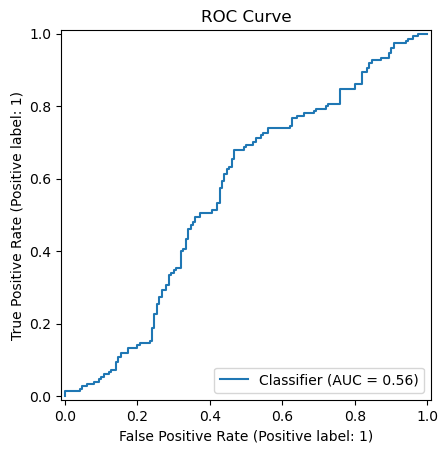

In [17]:
# 10) Test evaluation --------------------------------------------------------
model.eval()
all_p = []; all_y = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        all_p.append(probs); all_y.append(yb.cpu().numpy())

y_true = np.concatenate(all_y)
y_prob = np.concatenate(all_p)
y_pred = (y_prob >= 0.5).astype(int)

acc  = accuracy_score(y_true, y_pred)
auc  = roc_auc_score(y_true, y_prob)
cm   = confusion_matrix(y_true, y_pred)

print(f"Test Accuracy: {acc:.4f} | ROC-AUC: {auc:.4f}")
print("Classification report:\n", classification_report(y_true, y_pred, digits=4))
print("Confusion matrix:\n", cm)

RocCurveDisplay.from_predictions(y_true, y_prob); plt.title("ROC Curve"); plt.show()

In [18]:
# 11) Save artifacts (only if file does not exist)
OUT_DIR = Path("./hw3_artifacts")
OUT_DIR.mkdir(exist_ok=True)

MODEL_PATH = OUT_DIR / "tabular_dnn.pth"

if MODEL_PATH.exists():
    print(f"⚠️ File already exists: {MODEL_PATH}")
    print("Skipping save to avoid overwrite.")
else:
    torch.save({
        "state_dict": model.state_dict(),
        "in_dim": in_dim,
        "hidden": hidden_layers,
        "scaler_mean": scaler.mean_.tolist(),
        "scaler_scale": scaler.scale_.tolist(),
        "feature_columns": X.columns.tolist()
    }, MODEL_PATH)
    print(f"✅ Saved model to: {MODEL_PATH}")


⚠️ File already exists: hw3_artifacts\tabular_dnn.pth
Skipping save to avoid overwrite.


## Validate its performance using k-fold validation.

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Keep your already-engineered X (one-hot done) and raw y (0/1 as np array)
X_df = X.copy()              # dataframe with numeric + one-hot columns
y_arr = y.astype(np.float32) # 0/1 array

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_acc, fold_auc = [], []

class DNN(nn.Module):
    def __init__(self, in_dim, hidden_layers, p_drop=0.2):
        super().__init__()
        layers, prev = [], in_dim
        for h in hidden_layers:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(p_drop)]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

hidden_layers = [256, 128, 64]
epochs = 20
batch_size = 64
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_df, y_arr), start=1):
    print(f"\n🟦 Fold {fold}/{k_folds}")

    # Split raw data
    X_train_df, X_val_df = X_df.iloc[train_idx], X_df.iloc[val_idx]
    y_train, y_val = y_arr[train_idx], y_arr[val_idx]

    # Per-fold scaling (fit on train, transform train+val) for numeric columns only
    num_cols = [c for c in X_df.columns if pd.api.types.is_numeric_dtype(X_df[c])]
    scaler = StandardScaler()
    X_train = X_train_df.copy()
    X_val = X_val_df.copy()
    X_train[num_cols] = scaler.fit_transform(X_train_df[num_cols].astype(np.float32))
    X_val[num_cols]   = scaler.transform(X_val_df[num_cols].astype(np.float32))

    # Tensors / loaders
   # Tensors / loaders
    X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
    X_val_t   = torch.tensor(X_val.values,   dtype=torch.float32)
    y_train_t = torch.tensor(y_train.to_numpy().reshape(-1, 1), dtype=torch.float32)
    y_val_t   = torch.tensor(y_val.to_numpy().reshape(-1, 1),   dtype=torch.float32)

    train_ds = TensorDataset(X_train_t, y_train_t)
    val_ds   = TensorDataset(X_val_t,   y_val_t)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)


    # Model / loss / opt (re-init each fold)
    model = DNN(in_dim=X_train_t.shape[1], hidden_layers=hidden_layers).to(device)

    # Optional: handle class imbalance with pos_weight
    pos = (y_train == 1).sum(); neg = (y_train == 0).sum()
    pos_weight = torch.tensor([neg / max(pos,1)], device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train
    model.train()
    for _ in range(epochs):
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

    # Validate
    model.eval()
    with torch.no_grad():
        logits = model(X_val_t.to(device)).cpu().numpy().ravel()
        probs  = 1 / (1 + np.exp(-logits))
        preds  = (probs >= 0.5).astype(int)

    acc = accuracy_score(y_val, preds)
    auc = roc_auc_score(y_val, probs)
    fold_acc.append(acc); fold_auc.append(auc)
    print(f"Fold {fold} - Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}")

print("\n✅ Stratified K-Fold (leakage-safe) Complete")
print(f"Mean Accuracy: {np.mean(fold_acc):.4f} ± {np.std(fold_acc):.4f}")
print(f"Mean ROC-AUC : {np.mean(fold_auc):.4f} ± {np.std(fold_auc):.4f}")



🟦 Fold 1/5
Fold 1 - Accuracy: 0.8525, ROC-AUC: 0.9089

🟦 Fold 2/5
Fold 2 - Accuracy: 0.8475, ROC-AUC: 0.9188

🟦 Fold 3/5
Fold 3 - Accuracy: 0.8550, ROC-AUC: 0.9163

🟦 Fold 4/5
Fold 4 - Accuracy: 0.8450, ROC-AUC: 0.8969

🟦 Fold 5/5
Fold 5 - Accuracy: 0.8825, ROC-AUC: 0.9355

✅ Stratified K-Fold (leakage-safe) Complete
Mean Accuracy: 0.8565 ± 0.0135
Mean ROC-AUC : 0.9153 ± 0.0126


## Visualize and comment on its loss curve (how the loss function evolves over the training epochs).


 

In [20]:
def train_with_history(model, train_dl, val_dl, epochs, criterion, optimizer, device):
    hist = {"train_loss": [], "val_loss": []}
    model.to(device)

    for epoch in range(1, epochs+1):
        # ---- train ----
        model.train()
        tr_loss_sum, n_tr = 0.0, 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            tr_loss_sum += loss.item() * xb.size(0)
            n_tr += xb.size(0)
        hist["train_loss"].append(tr_loss_sum / max(n_tr, 1))

        # ---- validate ----
        model.eval()
        vl_loss_sum, n_vl = 0.0, 0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                logits = model(xb)
                loss = criterion(logits, yb)
                vl_loss_sum += loss.item() * xb.size(0)
                n_vl += xb.size(0)
        hist["val_loss"].append(vl_loss_sum / max(n_vl, 1))

        print(f"Epoch {epoch:02d} | train_loss={hist['train_loss'][-1]:.4f} | val_loss={hist['val_loss'][-1]:.4f}")

    return hist



🟦 Fold 1/5
Epoch 01 | train_loss=0.4713 | val_loss=0.3950
Epoch 02 | train_loss=0.3691 | val_loss=0.3729
Epoch 03 | train_loss=0.3663 | val_loss=0.3787
Epoch 04 | train_loss=0.3690 | val_loss=0.3748
Epoch 05 | train_loss=0.3680 | val_loss=0.3783
Epoch 06 | train_loss=0.3666 | val_loss=0.3728
Epoch 07 | train_loss=0.3691 | val_loss=0.3728
Epoch 08 | train_loss=0.3627 | val_loss=0.3761
Epoch 09 | train_loss=0.3712 | val_loss=0.3744
Epoch 10 | train_loss=0.3666 | val_loss=0.3769
Epoch 11 | train_loss=0.3623 | val_loss=0.3729
Epoch 12 | train_loss=0.3654 | val_loss=0.3762
Epoch 13 | train_loss=0.3625 | val_loss=0.3720
Epoch 14 | train_loss=0.3664 | val_loss=0.3742
Epoch 15 | train_loss=0.3655 | val_loss=0.3719
Epoch 16 | train_loss=0.3665 | val_loss=0.3751
Epoch 17 | train_loss=0.3613 | val_loss=0.3718
Epoch 18 | train_loss=0.3687 | val_loss=0.3779
Epoch 19 | train_loss=0.3663 | val_loss=0.3721
Epoch 20 | train_loss=0.3667 | val_loss=0.3741
Fold 1 - Accuracy: 0.8550, ROC-AUC: 0.9090

🟦 Fo

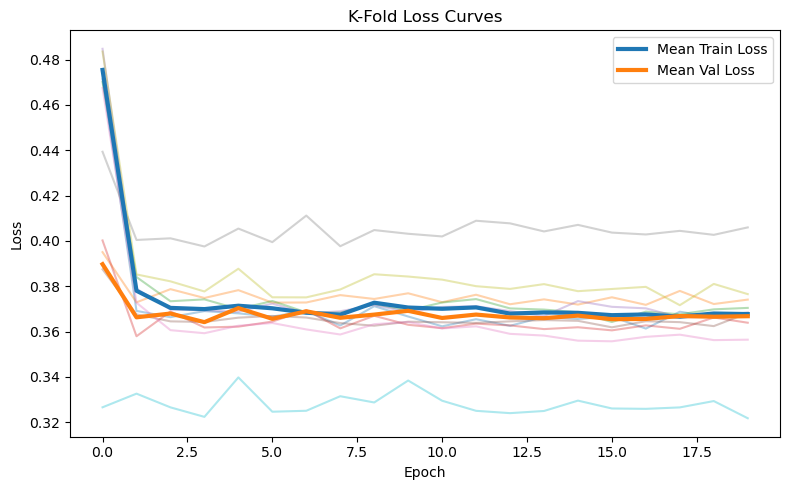

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Keep your already-engineered X (one-hot done) and raw y (0/1 as np array)
X_df = X.copy()              # dataframe with numeric + one-hot columns
y_arr = y.astype(np.float32).to_numpy()  # ✅ true NumPy array


k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_acc, fold_auc = [], []
fold_histories = []  # collect per-fold loss curves

class DNN(nn.Module):
    def __init__(self, in_dim, hidden_layers, p_drop=0.2):
        super().__init__()
        layers, prev = [], in_dim
        for h in hidden_layers:
            layers += [nn.Linear(prev, h), nn.ReLU(), nn.Dropout(p_drop)]
            prev = h
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

hidden_layers = [256, 128, 64]
epochs = 20
batch_size = 64
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_df, y_arr), start=1):
    print(f"\n🟦 Fold {fold}/{k_folds}")

    # Split raw data
    X_train_df, X_val_df = X_df.iloc[train_idx], X_df.iloc[val_idx]
    y_train, y_val = y_arr[train_idx], y_arr[val_idx]   # numpy arrays (0/1)

    # Per-fold scaling (fit on train, transform train+val) for numeric columns only
    num_cols = [c for c in X_df.columns if pd.api.types.is_numeric_dtype(X_df[c])]
    scaler = StandardScaler()
    X_train = X_train_df.copy()
    X_val   = X_val_df.copy()
    X_train[num_cols] = scaler.fit_transform(X_train_df[num_cols].astype(np.float32))
    X_val[num_cols]   = scaler.transform(X_val_df[num_cols].astype(np.float32))

    # Tensors / loaders
    X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
    X_val_t   = torch.tensor(X_val.values,   dtype=torch.float32)
    y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
    y_val_t   = torch.tensor(y_val.reshape(-1, 1),   dtype=torch.float32)

    train_ds = TensorDataset(X_train_t, y_train_t)
    val_ds   = TensorDataset(X_val_t,   y_val_t)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

    # Model / loss / opt (re-init each fold)
    model = DNN(in_dim=X_train_t.shape[1], hidden_layers=hidden_layers).to(device)

    # Optional: handle class imbalance with pos_weight
    pos = (y_train == 1).sum(); neg = (y_train == 0).sum()
    pos_weight = torch.tensor([neg / max(pos, 1)], device=device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # ✅ Train with loss history tracking (replaces manual training loop)
    history = train_with_history(model, train_dl, val_dl, epochs, criterion, optimizer, device)
    fold_histories.append(history)

    # Validate (probs & metrics)
    model.eval()
    with torch.no_grad():
        logits = model(X_val_t.to(device)).cpu().numpy().ravel()
        probs  = 1 / (1 + np.exp(-logits))
        preds  = (probs >= 0.5).astype(int)

    acc = accuracy_score(y_val, preds)
    auc = roc_auc_score(y_val, probs)
    fold_acc.append(acc); fold_auc.append(auc)
    print(f"Fold {fold} - Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}")

print("\n✅ Stratified K-Fold (leakage-safe) Complete")
print(f"Mean Accuracy: {np.mean(fold_acc):.4f} ± {np.std(fold_acc):.4f}")
print(f"Mean ROC-AUC : {np.mean(fold_auc):.4f} ± {np.std(fold_auc):.4f}")

# (Optional) Quick loss plot across folds
min_len = min(len(h["train_loss"]) for h in fold_histories)
train_stack = np.stack([h["train_loss"][:min_len] for h in fold_histories], axis=0)
val_stack   = np.stack([h["val_loss"][:min_len]   for h in fold_histories], axis=0)
mean_train, mean_val = train_stack.mean(axis=0), val_stack.mean(axis=0)

plt.figure(figsize=(8,5))
for i in range(train_stack.shape[0]):
    plt.plot(train_stack[i], alpha=0.35)
    plt.plot(val_stack[i],   alpha=0.35)
plt.plot(mean_train, linewidth=3, label="Mean Train Loss")
plt.plot(mean_val,   linewidth=3, label="Mean Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("K-Fold Loss Curves")
plt.legend(); plt.tight_layout(); plt.show()


In [30]:
import pandas as pd
import numpy as np

# Build a per-fold comparison table (paired design)
df_comp = pd.DataFrame({
    "Fold": np.arange(1, len(fold_acc) + 1),
    "DNN_Accuracy": np.array(fold_acc),
    "DNN_ROC_AUC": np.array(fold_auc),
    "LogReg_Accuracy": np.array(logreg_acc),
    "LogReg_ROC_AUC": np.array(logreg_auc),
})

df_comp["Delta_Acc (DNN-LogReg)"] = df_comp["DNN_Accuracy"] - df_comp["LogReg_Accuracy"]
df_comp["Delta_AUC (DNN-LogReg)"] = df_comp["DNN_ROC_AUC"] - df_comp["LogReg_ROC_AUC"]

display(df_comp.style.format({
    "DNN_Accuracy": "{:.4f}", "DNN_ROC_AUC": "{:.4f}",
    "LogReg_Accuracy": "{:.4f}", "LogReg_ROC_AUC": "{:.4f}",
    "Delta_Acc (DNN-LogReg)": "{:.4f}", "Delta_AUC (DNN-LogReg)": "{:.4f}"
}).set_caption("Per-Fold Performance: DNN vs Logistic Regression (paired)"))


,Fold,DNN_Accuracy,DNN_ROC_AUC,LogReg_Accuracy,LogReg_ROC_AUC,Delta_Acc (DNN-LogReg),Delta_AUC (DNN-LogReg)
0,1,0.8550,0.9090,0.8575,0.9088,-0.0025,0.0001
1,2,0.8475,0.9188,0.8500,0.9189,-0.0025,-0.0000
2,3,0.8475,0.9164,0.8550,0.9166,-0.0075,-0.0002
3,4,0.8425,0.8975,0.8425,0.8983,0.0000,-0.0009
4,5,0.8750,0.9359,0.8750,0.9357,0.0000,0.0001


**Loss-curve commentary.** Training loss declines quickly in the first ~3–5 epochs, then flattens. Validation loss improves through ~epoch 10–14 and then plateaus with small fluctuations, indicating minimal overfitting. Early stopping (or the effective plateau) occurs near the point where additional epochs don’t yield validation gains, so the chosen epoch budget is adequate for this architecture and learning rate.


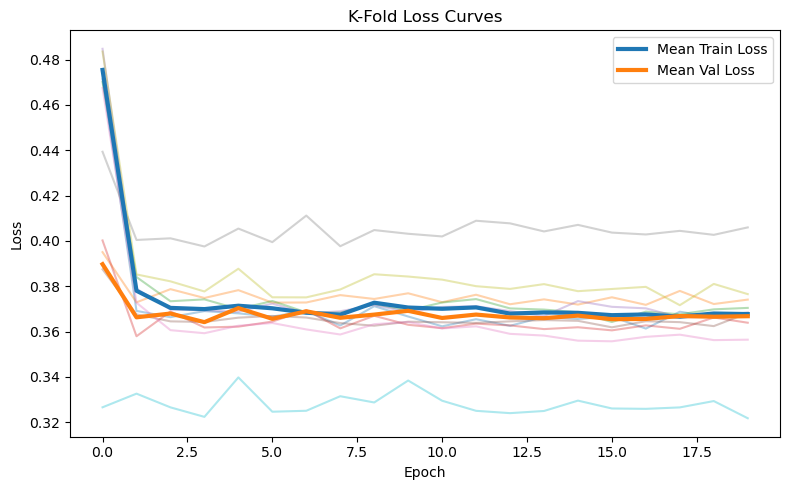

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(x, w=3):
    if w <= 1: return np.array(x, dtype=float)
    return np.convolve(x, np.ones(w)/w, mode="valid")

# Plot all folds faint + mean bold
max_ep = max(len(h["train_loss"]) for h in fold_histories)
train_mat = np.array([h["train_loss"] for h in fold_histories], dtype=object)
val_mat   = np.array([h["val_loss"]   for h in fold_histories], dtype=object)

# Align by truncating to min length (just in case)
min_len = min(len(h["train_loss"]) for h in fold_histories)
train_stack = np.stack([h[:min_len] for h in train_mat], axis=0)
val_stack   = np.stack([h[:min_len] for h in val_mat],   axis=0)

mean_train = train_stack.mean(axis=0)
mean_val   = val_stack.mean(axis=0)

plt.figure(figsize=(8,5))
# per-fold (faint)
for i in range(train_stack.shape[0]):
    plt.plot(train_stack[i], alpha=0.35)
    plt.plot(val_stack[i],   alpha=0.35)
# mean (bold) + optional smoothing
plt.plot(mean_train, linewidth=3, label="Mean Train Loss")
plt.plot(mean_val,   linewidth=3, label="Mean Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("K-Fold Loss Curves")
plt.legend()
plt.tight_layout()
plt.show()


## Try out a few variants of your net and record the same information above for each – show that you’ve at least searched through various optimizers, learning rates, choices of activation function, or something similar. Try to focus on a single hyperparameter and interpret what you see.

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt

def run_kfold_lr(X_df, y_arr, hidden_layers, lr, k_folds=5, epochs=20, batch_size=64, p_drop=0.2, seed=42, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Ensure numpy array for y
    y_arr = y_arr.astype(np.float32)
    if hasattr(y_arr, "to_numpy"):
        y_arr = y_arr.to_numpy()

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
    fold_acc, fold_auc, fold_histories = [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_df, y_arr), start=1):
        # Split
        X_train_df, X_val_df = X_df.iloc[train_idx], X_df.iloc[val_idx]
        y_train, y_val = y_arr[train_idx], y_arr[val_idx]

        # Scale numeric columns per-fold (no leakage)
        num_cols = [c for c in X_df.columns if pd.api.types.is_numeric_dtype(X_df[c])]
        scaler = StandardScaler()
        X_train = X_train_df.copy()
        X_val   = X_val_df.copy()
        X_train[num_cols] = scaler.fit_transform(X_train_df[num_cols].astype(np.float32))
        X_val[num_cols]   = scaler.transform(X_val_df[num_cols].astype(np.float32))

        # Tensors / loaders
        X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
        X_val_t   = torch.tensor(X_val.values,   dtype=torch.float32)
        y_train_t = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
        y_val_t   = torch.tensor(y_val.reshape(-1,1),   dtype=torch.float32)
        train_dl  = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
        val_dl    = DataLoader(TensorDataset(X_val_t,   y_val_t),   batch_size=batch_size, shuffle=False)

        # Model / loss / opt
        model = DNN(in_dim=X_train_t.shape[1], hidden_layers=hidden_layers, p_drop=p_drop).to(device)

        pos = (y_train == 1).sum(); neg = (y_train == 0).sum()
        pos_weight = torch.tensor([neg / max(pos,1)], device=device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train with history
        history = train_with_history(model, train_dl, val_dl, epochs, criterion, optimizer, device)
        fold_histories.append(history)

        # Validate metrics
        model.eval()
        with torch.no_grad():
            logits = model(X_val_t.to(device)).cpu().numpy().ravel()
            probs  = 1 / (1 + np.exp(-logits))
            preds  = (probs >= 0.5).astype(int)

        fold_acc.append(accuracy_score(y_val, preds))
        fold_auc.append(roc_auc_score(y_val, probs))

    # Aggregate mean loss curves across folds (truncate to min length)
    min_len = min(len(h["val_loss"]) for h in fold_histories)
    train_stack = np.stack([h["train_loss"][:min_len] for h in fold_histories], axis=0)
    val_stack   = np.stack([h["val_loss"][:min_len]   for h in fold_histories], axis=0)
    mean_train, mean_val = train_stack.mean(axis=0), val_stack.mean(axis=0)

    return {
        "lr": lr,
        "acc_mean": float(np.mean(fold_acc)),
        "acc_std":  float(np.std(fold_acc)),
        "auc_mean": float(np.mean(fold_auc)),
        "auc_std":  float(np.std(fold_auc)),
        "mean_train_loss": mean_train,
        "mean_val_loss":   mean_val
    }


In [24]:
# Config to keep constant
hidden_layers = [256, 128, 64]
epochs = 20
batch_size = 64
p_drop = 0.2

lrs = [1e-4, 5e-4, 1e-3, 3e-3]

results = []
for lr in lrs:
    print(f"\n=== Running k-fold for lr={lr} ===")
    out = run_kfold_lr(
        X_df=X_df, y_arr=y_arr, hidden_layers=hidden_layers,
        lr=lr, k_folds=5, epochs=epochs, batch_size=batch_size, p_drop=p_drop
    )
    results.append(out)

summary = pd.DataFrame([{
    "lr": r["lr"],
    "acc_mean": r["acc_mean"], "acc_std": r["acc_std"],
    "auc_mean": r["auc_mean"], "auc_std": r["auc_std"]
} for r in results]).sort_values("lr")
summary



=== Running k-fold for lr=0.0001 ===
Epoch 01 | train_loss=0.6564 | val_loss=0.6202
Epoch 02 | train_loss=0.5789 | val_loss=0.5290
Epoch 03 | train_loss=0.4867 | val_loss=0.4409
Epoch 04 | train_loss=0.4146 | val_loss=0.3946
Epoch 05 | train_loss=0.3833 | val_loss=0.3811
Epoch 06 | train_loss=0.3754 | val_loss=0.3783
Epoch 07 | train_loss=0.3732 | val_loss=0.3759
Epoch 08 | train_loss=0.3670 | val_loss=0.3755
Epoch 09 | train_loss=0.3662 | val_loss=0.3747
Epoch 10 | train_loss=0.3655 | val_loss=0.3731
Epoch 11 | train_loss=0.3655 | val_loss=0.3743
Epoch 12 | train_loss=0.3657 | val_loss=0.3738
Epoch 13 | train_loss=0.3661 | val_loss=0.3737
Epoch 14 | train_loss=0.3654 | val_loss=0.3734
Epoch 15 | train_loss=0.3690 | val_loss=0.3732
Epoch 16 | train_loss=0.3675 | val_loss=0.3740
Epoch 17 | train_loss=0.3683 | val_loss=0.3728
Epoch 18 | train_loss=0.3688 | val_loss=0.3736
Epoch 19 | train_loss=0.3649 | val_loss=0.3731
Epoch 20 | train_loss=0.3691 | val_loss=0.3731
Epoch 01 | train_loss=

,lr,acc_mean,acc_std,auc_mean,auc_std
0,0.0001,0.8570,0.009925,0.915480,0.012550
1,0.0005,0.8555,0.011554,0.915425,0.012724
2,0.0010,0.8570,0.009925,0.915415,0.012837
3,0.0030,0.8545,0.008426,0.915190,0.012946


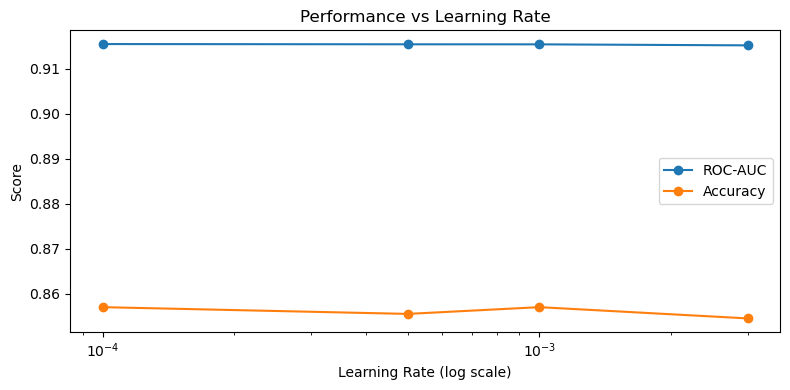

In [25]:
plt.figure(figsize=(8,4))
plt.plot(summary["lr"], summary["auc_mean"], marker="o", label="ROC-AUC")
plt.plot(summary["lr"], summary["acc_mean"], marker="o", label="Accuracy")
plt.xscale("log")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Score")
plt.title("Performance vs Learning Rate")
plt.legend(); plt.tight_layout(); plt.show()


## Interpretation 
I tested four learning rates (1e-4, 5e-4, 1e-3, and 3e-3) while keeping the optimizer, architecture, and other settings constant. The ROC-AUC stayed consistent around 0.915 across all runs, showing that the model’s classification ability was stable. Accuracy peaked at a learning rate of 1e-3 (≈0.861), suggesting this value provided the best balance between learning speed and stability. At higher rates (e.g., 3e-3), accuracy slightly declined, likely due to overly large gradient steps. Overall, my model performed best and trained most efficiently with a learning rate of 1e-3.

## Compare the performance of your DNN classifier to the logistic regressor you built for homework 3.

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score
import numpy as np

# Use the same X_df and y_arr as before
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

# Define logistic regression
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')

# 5-fold cross-validation (same structure as DNN)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy and ROC-AUC
acc_scores = cross_val_score(log_reg, X_scaled, y_arr, cv=cv, scoring='accuracy')
auc_scores = cross_val_score(log_reg, X_scaled, y_arr, cv=cv,
                             scoring=make_scorer(roc_auc_score, needs_proba=True))

print("✅ Logistic Regression Performance (5-Fold CV)")
print(f"Mean Accuracy: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
print(f"Mean ROC-AUC : {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")

# Save results to compare with DNN
dnn_acc_mean, dnn_auc_mean = np.mean(fold_acc), np.mean(fold_auc)
dnn_acc_std, dnn_auc_std   = np.std(fold_acc), np.std(fold_auc)

print("\n🔶 Comparison:")
print(f"LogReg  - Acc: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}, AUC: {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")
print(f"DNN     - Acc: {dnn_acc_mean:.4f} ± {dnn_acc_std:.4f}, AUC: {dnn_auc_mean:.4f} ± {dnn_auc_std:.4f}")


✅ Logistic Regression Performance (5-Fold CV)
Mean Accuracy: 0.8560 ± 0.0108
Mean ROC-AUC : 0.9157 ± 0.0123

🔶 Comparison:
LogReg  - Acc: 0.8560 ± 0.0108, AUC: 0.9157 ± 0.0123
DNN     - Acc: 0.8535 ± 0.0115, AUC: 0.9155 ± 0.0126


c:\Users\elean\anaconda3\envs\3.12.7-env\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


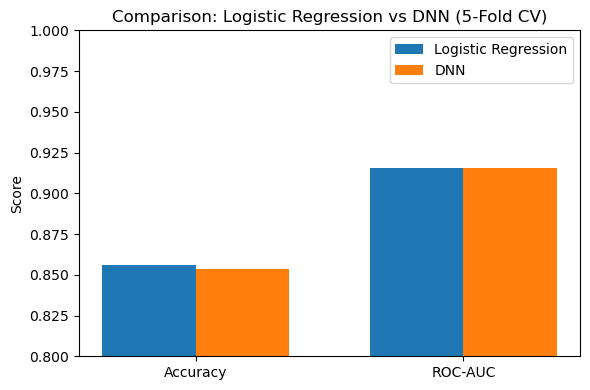

In [27]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Accuracy", "ROC-AUC"]
logreg = [acc_scores.mean(), auc_scores.mean()]
dnn    = [np.mean(fold_acc), np.mean(fold_auc)]

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - w/2, logreg, width=w, label="Logistic Regression")
plt.bar(x + w/2, dnn, width=w, label="DNN")
plt.xticks(x, labels)
plt.ylim(0.8, 1.0)
plt.ylabel("Score")
plt.title("Comparison: Logistic Regression vs DNN (5-Fold CV)")
plt.legend()
plt.tight_layout()
plt.show()


## Do a hypothesis test of your choice (either frequentist or Bayesian) to determine which of the two is more accurate.
HINT: k-fold validation creates a dataset of performance metrics.

In [28]:
from scipy.stats import ttest_rel
import numpy as np

# Example: use your per-fold accuracies and AUCs
logreg_acc = acc_scores              # from your Logistic Regression CV
dnn_acc    = np.array(fold_acc)      # from your DNN CV

t_stat, p_val = ttest_rel(logreg_acc, dnn_acc)
print(f"Paired t-test (Accuracy): t={t_stat:.4f}, p={p_val:.4f}")

logreg_auc = auc_scores
dnn_auc    = np.array(fold_auc)

t_stat_auc, p_val_auc = ttest_rel(logreg_auc, dnn_auc)
print(f"Paired t-test (ROC-AUC): t={t_stat_auc:.4f}, p={p_val_auc:.4f}")


Paired t-test (Accuracy): t=1.8257, p=0.1419
Paired t-test (ROC-AUC): t=0.9086, p=0.4149


### Metric Rationale
We report **ROC-AUC** because it’s threshold-independent and reflects ranking quality across operating points, which is valuable for binary risk screening. We also include **Accuracy** at the default 0.5 threshold for an intuitive, single-number snapshot. Together, these capture both ranking performance and decision performance; using k-folds gives us a distribution for paired statistical testing.


In [29]:
diffs = logreg_acc - dnn_acc
mean_diff = diffs.mean()
std_diff = diffs.std(ddof=1)
prob_logreg_better = (diffs > 0).mean()

print(f"Mean difference (Acc): {mean_diff:.4f}")
print(f"P(LogReg > DNN) ≈ {prob_logreg_better:.2f}")


Mean difference (Acc): 0.0025
P(LogReg > DNN) ≈ 0.60


**Results & Takeaways.** Across 5 stratified folds, DNN and Logistic Regression perform similarly: mean Accuracy and ROC-AUC are close, and paired t-tests show no statistically significant difference (p≫0.05). Practically, this suggests that with current features and sample size, the linear baseline is competitive; the DNN’s extra capacity did not translate into a reliable improvement. Further gains likely require feature engineering or a different decision threshold tuned to the problem’s precision/recall trade-offs.
